In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn import mixture
from sklearn import metrics
import sys
from scipy import stats
%matplotlib inline

# Data Preparation

In [26]:
def toMS(x):
    return ((x.hour*60+x.minute)*60+x.second)*1000000+x.microsecond
def timeDelta2MS(x):
    return (((x.hours*60+x.minutes)*60+x.seconds)*1000+x.milliseconds)*1000+x.microseconds
    
class DataPrep:
    ''' The parameters:
    1. isLean: whether we are dealing with data with more information. isLean=False, we have a richer data like the Training set. isLean=True, we have a lean data --only brief summary for each order
    2. decay_factor: a multiple of T_M (median trading gap)
    3. linger_factor: this is the multiple of the median trading gap. With this parameter, we will ignore all ordrers placed linger_factor*T_M ago
    '''
    
    def __init__(self,isLean=False,linger_factor = 40,decay_factor=5):        
        self.isLean = isLean
        self.linger_factor = linger_factor
        self.decay_factor = decay_factor
        self.medianT = 0 #the median of the trade interval
        
    def processDatafile(self,filename):
        data = pd.read_csv(filename)
        return self.processData(data)
    
    def processData(self,data,verbose=1):
        #import pdb;pdb.set_trace()
        if verbose>0:
            print '----Data cleaning----'
        if self.isLean:            
            allorder = self.cleanDataLean(data)
        else:
            allorder = self.cleanData(data)
    
        data = self.prepare(allorder)
        
        if verbose>0:
            print '---- Feature calculation----'
        #data = self.computeEWAVForward(data)
        allorder = self.computeEWAVBackward(data)
        #data = self.computeSEV(data)
        
        if verbose>0:
            print '----- Prepare for HMM------'
        data = self.HMMPrep(allorder.copy())
        
        return allorder,data
    
    def computeEWAVBackward(self,data):
        
        if len(data)<2:
            raise ValueError('data too short')
        
        #import pdb;pdb.set_trace()
        data['time diff'] = data['time diff'].fillna(24*3600*1000000)
        self.medianT = np.median(data['time diff'])
        T = self.medianT*self.decay_factor
        linger = self.medianT*self.linger_factor
        epsilon = sys.float_info.epsilon
        
        data['ewav_back canc buy'] = epsilon
        data['ewav_back canc sell'] = epsilon
        data['ewav_back exec buy'] = epsilon
        data['ewav_back exec sell'] = epsilon
    
        for ii in range(1,len(data)):
            coef = math.exp(-data.ix[ii]['time diff']/T) if data.ix[ii]['time diff']<=linger else 0
            data.loc[ii,'ewav_back canc buy'] = data.loc[ii,'cancelled buy']+data.loc[ii-1,'ewav_back canc buy']*coef
            data.loc[ii,'ewav_back canc sell'] = data.loc[ii,'cancelled sell']+data.loc[ii-1,'ewav_back canc sell']*coef
            data.loc[ii,'ewav_back exec buy'] = data.loc[ii,'exec buy']+data.loc[ii-1,'ewav_back exec buy']*coef
            data.loc[ii,'ewav_back exec sell'] = data.loc[ii,'exec sell']+data.loc[ii-1,'ewav_back exec sell']*coef
        ff = lambda x:x if x>epsilon else epsilon
        data['ewav_back canc buy'] = data['ewav_back canc buy'].map(ff)
        data['ewav_back canc sell'] = data['ewav_back canc sell'].map(ff)
        data['ewav_back exec buy'] = data['ewav_back exec buy'].map(ff)
        data['ewav_back exec sell'] = data['ewav_back exec sell'].map(ff)
      
        data['ewav_back buy/sell'] = data['ewav_back canc buy']/data['ewav_back canc sell'] 
        data['log ewav_back buy/sell'] = data['ewav_back buy/sell'].map(math.log)
        data['ewav_back sell/buy'] = data['ewav_back canc sell']/data['ewav_back canc buy']
                
        data['ewav_back buy exec+canc'] = data['ewav_back exec buy'] + data['ewav_back canc buy']
        data['ewav_back buy exec/total']=  data['ewav_back exec buy']/data['ewav_back buy exec+canc']       
       
        data['ewav_back sell exec+canc'] = data['ewav_back exec sell'] + data['ewav_back canc sell']
        data['ewav_back sell exec/total'] = data['ewav_back exec sell']/data['ewav_back sell exec+canc']
    
        return data
    
    def computeEWAVForward(self,data):
        if len(data)<2:
            raise ValueError('data too short')
        T=np.median(data['time diff'])*2
        data['ewav_for canc buy']=0
        data['ewav_for canc sell']=0
        data['ewav_for exec buy']=0
        data['ewav_for exec sell']=0
    
        for ii in range(len(data)-2,-1,-1):
            data.loc[ii,'ewav_for canc buy'] = data.loc[ii,'cancelled buy']+data.loc[ii+1,'ewav_for canc buy']*math.exp(-data.ix[ii+1]['time diff']/T)
            data.loc[ii,'ewav_for canc sell'] = data.loc[ii,'cancelled sell']+data.loc[ii+1,'ewav_for canc sell']*math.exp(-data.ix[ii+1]['time diff']/T)
            data.loc[ii,'ewav_for exec buy'] = data.loc[ii,'exec buy']+data.loc[ii+1,'ewav_for exec buy']*math.exp(-data.ix[ii+1]['time diff']/T)
            data.loc[ii,'ewav_for exec sell'] = data.loc[ii,'exec sell']+data.loc[ii+1,'ewav_for exec sell']*math.exp(-data.ix[ii+1]['time diff']/T)
        data['ewav_for buy/sell'] = 0
        data.loc[data['ewav_for canc sell']==0,'ewav_for buy/sell']= np.inf
        data.loc[data['ewav_for canc sell']!=0,'ewav_for buy/sell'] = data.loc[data['ewav_for canc sell']!=0,'ewav_for canc buy']/data.loc[data['ewav_for canc sell']!=0,'ewav_for canc sell']
    
        data['ewav_for sell/buy'] = 0
        data.loc[data['ewav_for canc buy']==0,'ewav_for sell/buy'] = np.inf
        data.loc[data['ewav_for canc buy']!=0,'ewav_for sell/buy'] = data.loc[data['ewav_for canc buy']!=0,'ewav_for canc sell']/data.loc[data['ewav_for canc buy']!=0,'ewav_for canc buy']
    
        data['ewav_for buy exec/total'] = 0
        data['ewav_for buy exec+canc'] = data['ewav_for exec buy'] + data['ewav_for canc buy']
        data.loc[data['ewav_for buy exec+canc']==0,'ewav_for buy exec/total']= 1
        data.loc[data['ewav_for buy exec+canc']!=0,'ewav_for buy exec/total'] = data.loc[data['ewav_for buy exec+canc']!=0,'ewav_for exec buy']/data.loc[data['ewav_for buy exec+canc']!=0,'ewav_for buy exec+canc']
    
        data['ewav_for sell exec/total'] = 0
        data['ewav_for sell exec+canc'] = data['ewav_for exec sell'] + data['ewav_for canc sell']
        data.loc[data['ewav_for sell exec+canc']==0,'ewav_for sell exec/total'] = 1
        data.loc[data['ewav_for sell exec+canc']!=0,'ewav_for sell exec/total'] = data.loc[data['ewav_for sell exec+canc']!=0,'ewav_for exec sell']/data.loc[data['ewav_for sell exec+canc']!=0,'ewav_for sell exec+canc']
    
        return data
    
    def computeSEV(self,data):
        data['sev buy']=0
        data['sev sell']=0
    
        winsize = 4*np.median(data['time diff'])
        top=len(data)-1
        tail = top
        while(top>=0):
            while tail>=top:
                if data.loc[tail,'microsecond']-data.loc[top,'microsecond'] <=winsize:
                    break
                tail-=1
            tmpbuy = 0.
            tmpsell = 0.
            for ii in range(top,tail+1):
                tmpbuy += data.loc[ii,'exec buy']
                tmpsell += data.loc[ii,'exec sell']
            data.loc[top,'sev buy']=tmpbuy
            data.loc[top,'sev sell']=tmpsell
            top -= 1
        data['sev net buy'] = data['sev buy'] - data['sev sell']
        data.loc[data['sev buy']==0,'sev sell/buy'] = np.inf
        data.loc[data['sev buy']!=0,'sev sell/buy'] = data.loc[data['sev buy']!=0,'sev sell']/data.loc[data['sev buy']!=0,'sev buy']*1.
        data.loc[data['sev sell']==0,'sev buy/sell'] = np.inf
        data.loc[data['sev sell']!=0,'sev buy/sell'] = data.loc[data['sev sell']!=0,'sev buy']/data.loc[data['sev sell']!=0,'sev sell']*1.
        return data  
    
    def cleanDataLean(self,data):
        #data['q_exec'].fillna(0,inplace=True)
        data['q_exec'].fillna(0,inplace=True)
        data['execution_time'] = data['execution_time'].map(lambda x:pd.to_datetime(x))
        data['cancel_entry_time'] = data['cancel_entry_time'].map(lambda x:pd.to_datetime(x))
        data['order_entry_time'] = data['order_entry_time'].map(lambda x:pd.to_datetime(x))
        
        allorder = data
        allorder['prc*qty'] = allorder['avg_prc']        
        allorder['execution_time_last_ms'] = allorder['execution_time'].map(toMS)
        allorder['order_entry_time_ms'] = allorder['order_entry_time'].map(toMS)
        
        allorder['q_cancel'] = allorder['q_new'] - allorder['q_exec']
        allorder.set_index('orderid',inplace=True)
        allorder = allorder.sort('order_entry_time')
        return allorder
    
    def cleanData(self,data):
        data['q_exec'].fillna(0,inplace=True)
        data['execution_time'] = data['execution_time'].map(lambda x:pd.to_datetime(x))
        data['cancel_entry_time'] = data['cancel_entry_time'].map(lambda x:pd.to_datetime(x))
        data['order_entry_time'] = data['order_entry_time'].map(lambda x:pd.to_datetime(x))
        data['prc*qty'] = data['q_exec']*data['prc_exec']

        neworder = data.loc[data['order_type']=='NEW ORDER',:]
        exeorder = data.loc[data['order_type']=='EXECUTION',:]
        canorder = data.loc[data['order_type']=='CANCEL',:].copy()
    
        ############## Exclude those partial filled orders from cancel list
        #partialfill = set(canorder['orderid']).intersection(set(exeorder['orderid']))
        #canorder = canorder.loc[canorder['orderid'].isin(partialfill)==False,:]
        #####################################################################
   
        allorder = neworder[['id','orderid','symbol','q_new','price','order_entry_time','date','time','side']].set_index('orderid')
        gp = exeorder.groupby('orderid')
        tmp = gp.agg({'q_exec':np.sum,'prc*qty':np.sum})
        tmp['avg exe_prc'] = tmp['prc*qty']/tmp['q_exec']
        del tmp['prc*qty']
        allorder = allorder.join(tmp)
    #allorder = allorder.join(gp['execute_time'].agg({'first_exe_time':np.min,'last_exe_time':np.max}))
        allorder = allorder.join(gp['execution_time'].agg({'first_execution_time':np.min,'last_execution_time':np.max}))
        allorder['execution_time_first_ms'] = allorder['first_execution_time'].map(toMS)
        allorder['execution_time_last_ms'] = allorder['last_execution_time'].map(toMS)
        allorder['order_entry_time_ms'] = allorder['order_entry_time'].map(toMS)
    #gp = canorder.groupby('orderid')
        allorder = allorder.join(canorder.set_index('orderid')[['cancel_entry_time','canc_time']])
        allorder['q_exec'].fillna(0,inplace=True)
        allorder['q_cancel'] = allorder['q_new'] - allorder['q_exec']
        allorder = allorder.sort('order_entry_time')
        return allorder
    
    def prepare(self,allorder):
        ''' resort all the order according the the order entry time (canceled order) and exe time(filled order)
            Calculate the time difference
        '''
        fillorder = allorder.loc[allorder['q_exec']>0,['date','price','side','last_execution_time','execution_time_last_ms','q_exec']]
        fillorder['exec buy'] = fillorder['q_exec']
        fillorder['exec sell'] = fillorder['q_exec']
        fillorder.loc[fillorder['side']=='B','exec sell'] = 0
        fillorder.loc[fillorder['side']!='B','exec buy'] = 0
        fillorder = fillorder.rename(columns={'execution_time_last_ms':'microsecond','last_execution_time':'time'})

    #canorder = allorder.loc[allorder['q_cancel']>0,['date','price','side','order_entry_time','order_entry_time_ms','q_cancel']]
        canorder = allorder.loc[allorder['q_cancel']==allorder['q_new'],['date','price','side','order_entry_time','order_entry_time_ms','q_cancel']]
    #partially filled order discarded
    #import pdb;pdb.set_trace()
        canorder['cancelled buy'] = canorder['q_cancel']
        canorder['cancelled sell'] = canorder['q_cancel']
        canorder.loc[canorder['side']=='B','cancelled sell'] = 0.0
        canorder.loc[canorder['side']!='B','cancelled buy'] = 0.0
        canorder = canorder.rename(columns={'order_entry_time_ms':'microsecond','order_entry_time':'time'})

        fillorder['cancelled buy'] = 0
        fillorder['cancelled sell'] = 0
        canorder['exec buy'] = 0
        canorder['exec sell'] = 0
        del canorder['q_cancel']
        del fillorder['q_exec']
        data = fillorder.append(canorder)
        data = data.sort(['date','microsecond'])
        data = data.reset_index()
        #import pdb;pdb.set_trace()
        for dd in data['date'].unique():
            data.loc[data['date']==dd,'inventory'] = data.loc[data['date']==dd,'exec buy']-data.loc[data['date']==dd,'exec sell']
            data.loc[data['date']==dd,'inventory'] = data.loc[data['date']==dd,'inventory'].cumsum()
            data.loc[data['date']==dd,'time diff']= data.loc[data['date']==dd,'microsecond'].diff()*1. 
        data['time diff'] = data['time diff'].fillna(24*3600*1000000)
        return data
    
    def HMMPrep(self,df):
        #import pdb;pdb.set_trace()
        col = ['orderid','cancelled buy','exec sell','cancelled sell','exec buy','microsecond','price','side','time','date','inventory','time diff',
         'ewav_back canc buy','ewav_back canc sell','ewav_back exec buy','ewav_back exec sell','ewav_back buy/sell','ewav_back sell/buy']
        if 'IsSpoof' in df.columns:
            col +=['IsSpoof']
        df = df[col]
        del df['ewav_back exec buy']
        del df['ewav_back exec sell']
        # clean the data for ewav_back canc buy/sell and sell/buy
        # buy/sell will be just inverse of sell/buy, so we use one column buy/sell
        df.loc[(df['ewav_back canc buy']<1e-5)&(df['ewav_back canc sell']<1e-5),'ewav_back buy/sell']=1
        medianbs = df.loc[(df['ewav_back buy/sell']>0)&(df['ewav_back buy/sell']<np.inf),'ewav_back buy/sell'].median()
        maxbs = df.loc[(df['ewav_back buy/sell']>0)&(df['ewav_back buy/sell']<np.inf),'ewav_back buy/sell'].max()
        df.loc[df['ewav_back buy/sell']==np.inf,'ewav_back buy/sell'] = maxbs
        df.loc[df['ewav_back buy/sell']==0,'ewav_back buy/sell'] = 1/maxbs
        df.loc[:,'ewav_back buy/sell'] = df.loc[:,'ewav_back buy/sell'].map(np.log)
        
        ## Get the time difference, seems not contributing for now
        df['TimeDiff_back'] = np.nan
        df['TimeDiff_frwd'] = np.nan
        df['TimeDiff_min'] = np.nan
        #import pdb;pdb.set_trace()
        
        df = df.loc[(df['exec sell']>0)|(df['exec buy']>0),:].copy()
        if len(df)==0:
            return df
        buy = df.loc[df['side']=='B',:].copy()
        if len(buy)>0:
            for dd in buy['date'].unique():
            #import pdb;pdb.set_trace()
                tmp = buy.loc[buy['date']==dd,:]
                buy.loc[buy['date']==dd,'TimeDiff_back'] = buy.loc[buy['date']==dd,'microsecond'].diff(1).map(lambda x:np.abs(x))
                buy.loc[buy['date']==dd,'TimeDiff_frwd'] = buy.loc[buy['date']==dd,'microsecond'].diff(-1).map(lambda x:np.abs(x))
            #import pdb;pdb.set_trace()    
            buy['TimeDiff_frwd'].fillna(buy['TimeDiff_frwd'].max(),inplace=True)    
            buy['TimeDiff_back'].fillna(buy['TimeDiff_back'].max(),inplace=True)
            buy['TimeDiff_min'] = buy.apply(lambda x:min(x['TimeDiff_back'],x['TimeDiff_frwd']),axis=1)

        sell = df.loc[df['side']=='S',:].copy()
        if len(sell)>0:
            for dd in sell['date'].unique():
                tmp = sell.loc[sell['date']==dd,:]
                sell.loc[sell['date']==dd,'TimeDiff_back'] = sell.loc[sell['date']==dd,'microsecond'].diff(1).map(lambda x:np.abs(x))
                sell.loc[sell['date']==dd,'TimeDiff_frwd'] = sell.loc[sell['date']==dd,'microsecond'].diff(-1).map(lambda x:np.abs(x))
    
            sell['TimeDiff_frwd'].fillna(sell['TimeDiff_frwd'].max(),inplace=True)
            sell['TimeDiff_back'].fillna(sell['TimeDiff_back'].max(),inplace=True)
            sell['TimeDiff_min'] = sell.apply(lambda x:min(x['TimeDiff_back'],x['TimeDiff_frwd']),axis=1)

        newdf = buy.append(sell)
        newdf['date'] = newdf['date'].map(lambda x:pd.to_datetime(x))
        #newdf = newdf.sort(['date','microsecond'])
        df = newdf.sort()
        
        return df


    

# Prepare the training set

In [23]:
def prepareTrainSet():    
    df = pd.read_csv('labeled_sina.csv')
    df = df[['orderid','IsSpoof','cancelled buy','exec sell','cancelled sell','exec buy','microsecond','price','side','time','date','inventory','time diff',
         'ewav_back canc buy','ewav_back canc sell','ewav_back exec buy','ewav_back exec sell','ewav_back buy/sell','ewav_back sell/buy']]
    del df['ewav_back exec buy']
    del df['ewav_back exec sell']
    # clean the data for ewav_back canc buy/sell and sell/buy
    # buy/sell will be just inverse of sell/buy, so we use one column buy/sell
    
    df.loc[(df['ewav_back canc buy']<1e-5)&(df['ewav_back canc sell']<1e-5),'ewav_back buy/sell']=1
    medianbs = df.loc[(df['ewav_back buy/sell']>0)&(df['ewav_back buy/sell']<np.inf),'ewav_back buy/sell'].median()
    maxbs = df.loc[(df['ewav_back buy/sell']>0)&(df['ewav_back buy/sell']<np.inf),'ewav_back buy/sell'].max()
    df.loc[df['ewav_back buy/sell']==np.inf,'ewav_back buy/sell'] = maxbs
    df.loc[df['ewav_back buy/sell']==0,'ewav_back buy/sell'] = 1/maxbs
    df['ewav_back buy/sell'] = df['ewav_back buy/sell'].map(np.log)
    # To get the time difference between current trade and its nearest trade at the same side
    df['TimeDiff_back'] = np.nan
    df['TimeDiff_frwd'] = np.nan
    df['TimeDiff_min'] = np.nan
    df = df.loc[(df['exec sell']>0)|(df['exec buy']>0),:].copy()

    buy = df.loc[df['side']=='B',:].copy()
    for dd in buy['date'].unique():
        #import pdb;pdb.set_trace()
        tmp = buy.loc[buy['date']==dd,:]
        buy.loc[buy['date']==dd,'TimeDiff_back'] = buy.loc[buy['date']==dd,'microsecond'].diff(1).map(lambda x:np.abs(x))
        buy.loc[buy['date']==dd,'TimeDiff_frwd'] = buy.loc[buy['date']==dd,'microsecond'].diff(-1).map(lambda x:np.abs(x))
    #import pdb;pdb.set_trace()    
    buy['TimeDiff_frwd'] = buy['TimeDiff_frwd'].fillna(buy['TimeDiff_frwd'].max())    
    buy['TimeDiff_back'] = buy['TimeDiff_back'].fillna(buy['TimeDiff_back'].max())
    buy['TimeDiff_min'] = buy.apply(lambda x:min(x['TimeDiff_back'],x['TimeDiff_frwd']),axis=1)

    sell = df.loc[df['side']=='S',:].copy()
    for dd in sell['date'].unique():
        tmp = sell.loc[sell['date']==dd,:]
        sell.loc[sell['date']==dd,'TimeDiff_back'] = sell.loc[sell['date']==dd,'microsecond'].diff(1).map(lambda x:np.abs(x))
        sell.loc[sell['date']==dd,'TimeDiff_frwd'] = sell.loc[sell['date']==dd,'microsecond'].diff(-1).map(lambda x:np.abs(x))
    
    sell['TimeDiff_frwd'] = sell['TimeDiff_frwd'].fillna(sell['TimeDiff_frwd'].max())
    sell['TimeDiff_back'] = sell['TimeDiff_back'].fillna(sell['TimeDiff_back'].max())
    sell['TimeDiff_min'] = sell.apply(lambda x:min(x['TimeDiff_back'],x['TimeDiff_frwd']),axis=1)

    newdf = buy.append(sell)
    newdf['date'] = newdf['date'].map(lambda x:pd.to_datetime(x))
    #newdf = newdf.sort(['date','microsecond'])
    df = newdf.sort()
    #Define states
    s1 = {'side':'B','IsSpoof':False}
    s2 = {'side':'S','IsSpoof':False}
    s3 = {'side':'B','IsSpoof':True}
    s4 = {'side':'S','IsSpoof':True}

    df['state']=0
    df.loc[(df['side']=='B')&(df['IsSpoof']==False),'state'] = 0
    df.loc[(df['side']=='S')&(df['IsSpoof']==False),'state'] = 1
    df.loc[(df['side']=='B')&(df['IsSpoof']==True),'state'] = 2
    df.loc[(df['side']=='S')&(df['IsSpoof']==True),'state'] = 3
    
    return df

In [5]:
def prepareTrainSetRec():
    '''Each time the train data are loaded, all the features are calculated as the test set
    '''
    data = pd.read_csv('labeled_sina.csv')
    #import pdb;pdb.set_trace()
    dp = DataPrep()
    allorder = dp.computeEWAVBackward(data)
    hmmdata = dp.HMMPrep(allorder.copy())
    
    hmmdata['state']=0
    hmmdata.loc[(hmmdata['side']=='B')&(hmmdata['IsSpoof']==False),'state'] = 0
    hmmdata.loc[(hmmdata['side']=='S')&(hmmdata['IsSpoof']==False),'state'] = 1
    hmmdata.loc[(hmmdata['side']=='B')&(hmmdata['IsSpoof']==True),'state'] = 2
    hmmdata.loc[(hmmdata['side']=='S')&(hmmdata['IsSpoof']==True),'state'] = 3
    return hmmdata
    

# Single Gaussian Component with Robust Covariance Estimator

In [6]:
from sklearn.covariance import MinCovDet
from scipy.stats import multivariate_normal

class GauModel:
    def __init__(self):
        #self.mu = np.None
        #self.sigma = np.None
        self.normRV = None
        
    
    def fit(self,data):
        robust_cov = MinCovDet().fit(data)
        self.normRV = multivariate_normal(mean = robust_cov.location_,cov=robust_cov.covariance_)
    
    def score(self,x):
        return self.normRV.logpdf(x)
        

In [7]:
from scipy import stats
class GammaModel:
    def __init__(self,sign=1):
        #self.loc = 0
        self.alpha = 1.5
        #self.beta = 0
        self.gammaRV = None
        self.sign = sign
        
    def fit(self,data):
        #import pdb;pdb.set_trace()
        tmpdata = np.asarray(data)
        #tmpdata = tmpdata[tmpdata!=0] #we consider the data==0 as outlier
        datamedian = np.median(tmpdata)
        if datamedian < 0 :
            self.sign = -1
        tmpdata = tmpdata*self.sign
        th = np.percentile(tmpdata,1)
        tmpdata = tmpdata[tmpdata>th] # we consider the data lower 2 percent as outliers
        
        
        #fit_alpha, fit_loc, fit_beta=stats.gamma.fit(tmpdata)
        fit_alpha,fit_loc,fit_beta = self.fitFixedAlpha(tmpdata)
        self.gammaRV = stats.gamma(fit_alpha,loc=0, scale=fit_beta)
        #self.alpha = fit_alpha
        self.beta = fit_beta
        self.loc = 0
        
        if False:
            plt.hist(tmpdata,bins=100,normed=True)
            tt = np.arange(0,20,0.01)
            yy = self.gammaRV.pdf(tt)
            plt.plot(tt,yy)
            plt.show()
    
    def fitFixedAlpha(self,data):
        alpha = self.alpha
        loc = 0
        beta = np.mean(data)/alpha
        
        return alpha,loc,beta
        
        
    def score(self,x):     
        xx = np.array(x)
        #xx[xx==0] = sys.float_info.min
        res = self.gammaRV.logpdf(xx*self.sign)
        res[xx==0]=-1e30
        #print xx[res==np.inf]
        return res
        

In [24]:

class GammaExpModel:
    ''' Mixture of Gamma distribution and a Delta at zero
        Eventually, we want a mixture of Exponential distribution and a Gamma
    '''
    def __init__(self,sign=1,alpha=1.5,outlierRem = True):
        '''
        The model is f(x) = pi*exp(mu) + (1-pi)*Gamma(1.5,scale)
        alpha: alpha parameter for the Gamma model
        '''
        #self.loc = 0
        self.alpha = alpha
        self.mu = 0
        self.beta = 0
        self.gammaRV = None
        self.ExpRV = None
        self.pi = 0.5
        self.sign = sign
        self.outlierRem = outlierRem
        self.auto = True # where to automatically determine the sign of the data
        
    def RemOutlier(self,data):
        ''' remove the outlier
        '''
        th = np.percentile(tmpdata,1)
        tmpdata = tmpdata[tmpdata>th] # we consider the data lower 2 percent as outliers
        return tmpdata
        
    def fit(self,data):
        ''' using EM algorithm to find out the parameters of the components
        '''
        #import pdb;pdb.set_trace()
        tmpdata = np.asarray(data)
        if self.auto:
            datamedian = np.median(tmpdata)
            if datamedian < 0 :
                self.sign = -1
        tmpdata = tmpdata*self.sign
        tmpdata = tmpdata[tmpdata>=0]
        if self.outlierRem:
            th1 = np.percentile(tmpdata,3)
            th2 = np.percentile(tmpdata,97)
            tmpdata = tmpdata[tmpdata>th1] # we consider the data lower 2 percent as outliers
            tmpdata = tmpdata[tmpdata<th2]
        
        nIter = 0
        self.mu = np.percentile(tmpdata,10)
        self.beta =  np.percentile(tmpdata,50)/self.alpha #initial values
        
        while nIter<100:            
            p0 = stats.expon.pdf(tmpdata,scale=self.mu)*self.pi
            p1 = stats.gamma.pdf(tmpdata,a = self.alpha,loc=0,scale=self.beta)*(1-self.pi)
            p = p0+p1
            r = p0/p
            
            #for ii in range(len(p0)):
            #    print 'ii={}, r={}'.format(ii,p0[ii]/p[ii])
            #    if p0[ii]/p[ii] is np.nan:
            #        print p0[ii],p[ii],p1[ii]
            
            old_mu = self.mu
            old_beta = self.beta
            self.mu = np.sum(r*tmpdata )/np.sum(r)
            self.beta = np.sum((1-r)*tmpdata)/np.sum(1-r)/self.alpha
            self.pi = np.mean(r)
            #print self.mu,self.beta
            if np.abs(self.mu - old_mu)<sys.float_info.epsilon and np.abs(self.beta -old_beta)<sys.float_info.epsilon:
                break
            nIter +=1
        
        #import pdb;pdb.set_trace()
        #print nIter
        if False:
            plt.hist(tmpdata,bins=100,normed=True)
            tt = np.arange(0,20,0.01)
            yy = self.pdf(tt)
            plt.plot(tt,yy)
            ttt = np.arange(0,50,0.01)
            zz = stats.gamma.pdf(ttt,self.alpha,loc=0,scale=self.beta)*(1-self.pi)
            plt.plot(ttt,zz)
            plt.show()
            
    def pdf(self,x):
        y = stats.expon.pdf(x,scale=self.mu)*self.pi + stats.gamma.pdf(x,self.alpha,loc=0,scale=self.beta)*(1-self.pi)
        return y
    def score(self,x):
        y = self.pdf(x)
        return np.log(y)
    
#    def fitFixedAlpha(self,data):
#        alpha = self.alpha
#        loc = 0
#        beta = np.mean(data)/alpha
        
#        return alpha,loc,beta
        
        
#    def score(self,x):     
#        xx = np.array(x)
#        #xx[xx==0] = sys.float_info.min
#        res = self.gammaRV.logpdf(xx*self.sign)
#        res[xx==0]=-1e30
#        #print xx[res==np.inf]
#        return res

In [8]:
from scipy import stats
class GammaDiracModel:
    ''' Mixture of Gamma distribution and a Delta at zero
        Eventually, we want a mixture of Exponential distribution and a Gamma
    '''
    def __init__(self,sign=1,alpha=1.5,outlierRem = True):
        '''
        The model is f(x) = pi*exp(mu) + (1-pi)*Gamma(1.5,scale)
        alpha: alpha parameter for the Gamma model
        '''
        #self.loc = 0
        self.alpha = alpha
        self.pi = 0.2
        self.beta = 0
        self.sign = sign
        self.outlierRem = outlierRem
        self.auto = True # where to automatically determine the sign of the data
        
    def RemOutlier(self,data):
        ''' remove the outlier
        '''
        th = np.percentile(tmpdata,1)
        tmpdata = tmpdata[tmpdata>th] # we consider the data lower 2 percent as outliers
        return tmpdata
        
    def fit(self,data):
        ''' using EM algorithm to find out the parameters of the components
        '''
        #import pdb;pdb.set_trace()
        tmpdata = np.asarray(data)
        if self.auto:
            datamedian = np.median(tmpdata)
            if datamedian < 0 :
                self.sign = -1
        tmpdata = tmpdata*self.sign
        tmpdata = tmpdata[tmpdata>=0]
        if self.outlierRem:
            th1 = np.percentile(tmpdata,3)
            th2 = np.percentile(tmpdata,97)
            tmpdata = tmpdata[tmpdata>th1] # we consider the data lower 2 percent as outliers
            tmpdata = tmpdata[tmpdata<th2]
        
        self.pi = len(tmpdata[tmpdata==0])*1.0/len(tmpdata)
        self.beta = np.mean(tmpdata[tmpdata>0])/self.alpha
        if True:
            plt.hist(tmpdata,bins=100,normed=True)
            tt = np.arange(0,20,0.01)
            yy = self.pdf(tt)
            plt.plot(tt,yy)
            ttt = np.arange(0,50,0.01)
            zz = stats.gamma.pdf(ttt,self.alpha,loc=0,scale=self.beta)*(1-self.pi)
            plt.plot(ttt,zz)
            plt.show()
            
    def pdf(self,x):
        y = stats.gamma.pdf(x,self.alpha,loc=0,scale=self.beta)*(1-self.pi)
        y[x==0] = self.pi
        y[x<0] = 0
        return y
    def score(self,x):
        y = self.pdf(x)
        return np.log(y)

In [9]:
from sklearn.ensemble import RandomForestClassifier
class RFModel:
    def __init__(self,n_estimators,max_depth):
        self.rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        self.label_map = {}
        self.rev_map = {}
        
        #self.label_set = label_set
        
    def fit(self,x1,label1,x2,label2):
        ''' we assume x1,x2 are numpy arrays (1-d)
        '''
       
        label = np.array([0]*len(x1)+[1]*len(x2))
        self.label_map = {0:label1,1:label2}
        self.rev_map ={label1:0,label2:1}
        data = np.concatenate((x1,x2)).reshape((len(x1)+len(x2),1))
        self.rf.fit(data,label)
        
        if True:
            self.showResult(x1,label1,x2,label2)
    
    def showResult(self,x1,label1,x2,label2):
        #import pdb;pdb.set_trace()
        plt.hist(np.array(x1),bins=100,alpha=0.5,normed=True)
        plt.hist(np.array(x2),bins=100,alpha=0.5,normed=True)
        tt = np.arange(-50,50,0.05)
        tt = tt.reshape((len(tt),1))
        proba = self.rf.predict_proba(tt)
        plt.plot(tt,proba[:,0],color='b')
        plt.plot(tt,proba[:,1],color='r')
        plt.show()
        
    def score(self,x,label):
        ''' give score in log prob for the class denoted by label
        '''
        proba = self.rf.predict_proba(np.array(x).reshape((len(x),1)))
        return np.log(proba[:,self.rev_map[label]])
    
    def prob(self,x,label):
        ''' give score in log prob for the class denoted by label
        '''
        proba = self.rf.predict_proba(np.array(x).reshape((len(x),1)))
        return proba[:,self.rev_map[label]]
    
    
class RFWrapper():
    def __init__(self,rf,label):
        self.rf = rf
        self.label= label
    def score(self,x):
        return self.rf.score(x,self.label)
    def prob(self,x):
        return self.rf.prob(x,self.label)
    

# Hidden Markov Model 

In [10]:

class HMM:
    def __init__(self,nState,TDFeaSet,featureSet,useAllFea,useDPGMM=True):
        '''
        recommended value for featureSet=['ewav_back buy/sell']
        '''
        self.TDFeaSet = TDFeaSet
        self.featureSet = featureSet
        self.useDPGMM = useDPGMM
        self.useAllFea = useAllFea
        #self.df = data
        self.nState = nState
        self.tp = None
        self.pi = None
        self.TDmodel = []
        self.RatioModel = []
    
    def DefStates(self,df):
        '''Define states, return data
        '''        
        s1 = {'side':'B','IsSpoof':False}
        s2 = {'side':'S','IsSpoof':False}
        s3 = {'side':'B','IsSpoof':True}
        s4 = {'side':'S','IsSpoof':True}
        df = df.loc[(df['exec sell']>0)|(df['exec buy']>0),:].copy()
        df['state']=0
        df.loc[(df['side']=='B')&(df['IsSpoof']==False),'state'] = 0
        df.loc[(df['side']=='S')&(df['IsSpoof']==False),'state'] = 1
        df.loc[(df['side']=='B')&(df['IsSpoof']==True),'state'] = 2
        df.loc[(df['side']=='S')&(df['IsSpoof']==True),'state'] = 3
        return df

    
    def fitGaussModel(self,data,showPara=True):
        ''' fits the emission model for each state
        '''
        dpgmm = GauModel()
        dpgmm.fit(data)
        if showPara:
            print '------------------'
            print '------mean--------'
            print dpgmm.normRV.mean
            print '-----Covariance----'
            print dpgmm.normRV.cov
            print '-------------------'
        return dpgmm
        #if self.useDPGMM==True:
        #    dpgmm = mixture.DPGMM(n_components=5)
        #else:
        #    dpgmm = mixture.GMM(n_components=2)
        
        #dpgmm.fit(data)
        #return dpgmm
        
    def fitGammaExpModel(self,data,showPara=True):
        ''' fits the emission model for each state, using gamma(2) pdf
        '''
        dpgmm = GammaExpModel()
        dpgmm.fit(data)
        if showPara:
            print '------------------'
            print '------sign--------'
            print dpgmm.sign
            print '-----mu----'
            print dpgmm.mu
            print '-----alpha-------'
            print dpgmm.alpha
            print '-----beta--------'
            print dpgmm.beta
            print '-------------------'
        return dpgmm
    
    def fitGammaDiracModel(self,data,showPara=True):
        ''' fits the emission model for each state, using gamma(2) pdf
        '''
        dpgmm = GammaDiracModel()
        dpgmm.fit(data)
        if showPara:
            print '------------------'
            print '------sign--------'
            print dpgmm.sign
            print '---- pi-----'
            print dpgmm.pi
            print '-----alpha-------'
            print dpgmm.alpha
            print '-----beta--------'
            print dpgmm.beta
            print '-------------------'
        return dpgmm
    
    def fitGammaModel(self,data,showPara=True):
        ''' fits the emission model for each state, using gamma(2) pdf
        '''
        dpgmm = GammaModel()
        dpgmm.fit(data)
        if showPara:
            print '------------------'
            print '------sign--------'
            print dpgmm.sign
            print '-----location----'
            print dpgmm.loc
            print '-----alpha-------'
            print dpgmm.alpha
            print '-----beta--------'
            print dpgmm.beta
            print '-------------------'
        return dpgmm
    
    def fitMixModel(self,data,showPara=True):
        ''' fits the emission model for each state
        '''
        #if self.useDPGMM==True:
        #    dpgmm = mixture.DPGMM(n_components=5)
        #else:
        dpgmm = mixture.GMM(n_components=2)        
        dpgmm.fit(data)
        
        if showPara:
            print '-------------------'
            print '------The mean------'
            print dpgmm.means_
            print '------The co-variance ---'
            print dpgmm.covars_
            print '------------------'
        return dpgmm
    
    
    def train(self,df,show=False):
        self.pi = np.array(df.groupby('state').size()*1.0/len(df))
        
        df['next state'] = df['state'].shift(-1)    
        xx = pd.DataFrame()
        for dd in df['date'].unique():
            tmp = df.loc[df['date']==dd,:].copy()
            tmp = tmp.reset_index(drop=True)
            tmp = tmp.ix[0:len(tmp)-2]
            if len(tmp)<1:
                continue
            xx = xx.append(tmp)

        gp = xx.groupby(['state','next state','date']).size()
        aa = gp.sum(level=[0,1])
        bb = gp.sum(level=0)*1.
        self.tp = aa/bb

        print '---- Transition prob'
        print self.tp
        self.TDmodel = []
        self.RatioModel = []
        
        ### RF model for ratio #############
        
        ratio0 = df.loc[df['state']==0,self.featureSet]
        ratio2 = df.loc[df['state']==2,self.featureSet]
        rf_buy = RFModel(n_estimators=10,max_depth=2)
        rf_buy.fit(ratio0,0,ratio2,2)
        
        ratio1 = df.loc[df['state']==1,self.featureSet]
        ratio3 = df.loc[df['state']==3,self.featureSet]
        rf_sell = RFModel(n_estimators=10,max_depth=2)
        rf_sell.fit(ratio1,1,ratio3,3)
        
        self.RatioModel=[RFWrapper(rf_buy,0),RFWrapper(rf_sell,1),RFWrapper(rf_buy,2),RFWrapper(rf_sell,3)]
        
        #print ratio0
        #print '------------------'
        #print ratio2
        
        #ttt = np.arange(-10,10,0.5)
        #xxx = ttt.reshape((len(ttt),1))
        #print rf_buy.prob(xxx,0)
        #print rf_buy.prob(xxx,2)
        
        #print self.RatioModel[0].prob(xxx)
        #print self.RatioModel[2].prob(xxx)
        
        #import pdb;pdb.set_trace()               
        
        for state in range(self.nState):
            #import pdb;pdb.set_trace()
            td = df.loc[df['state']==state,self.TDFeaSet]
            #ratio = df.loc[df['state']==state,self.featureSet]
            m1 = self.fitMixModel(td,showPara=False)
            self.TDmodel.append(m1)
        if show:
            self.plotDist2x(self.RatioModel[0],np.arange(-10,10,0.25),self.RatioModel[2],np.arange(-10,1e-5,0.25))
            self.plotDist2x(self.RatioModel[1],np.arange(-10,10,0.25),self.RatioModel[3],np.arange(1e-5,10,0.25))
    
    def plotDist(self,model):
        xx = np.arange(-10,10,0.25)
        yy = model.score(xx)
        plt.plot(xx,yy)
    
    def plotDist2(self,model1,model2):
        xx = np.arange(-10,10,0.25)
        yy1 = model1.score(xx)
        yy2 = model2.score(xx)
        plt.plot(xx,yy1,'*',xx,yy2,'x')
        plt.show()
    
    def plotDist2x(self,model1,x1,model2,x2):
        #xx = np.arange(-10,10,0.25)
        yy1 = model1.score(x1)
        yy2 = model2.score(x2)
        plt.plot(x1,yy1,'*',x2,yy2,'x')
        plt.show()
    
    def stateEstimator(self,obs):
        ''' Estimate the most likely state sequence given the sequence of observations
        The data (obs) should be only one day data
        '''
        nState = self.nState
        TDmodel = self.TDmodel
        RatioModel = self.RatioModel
        tdlist = []
        rtlist = []
    
        for td in TDmodel:
            tdlist.append(td.score(obs[self.TDFeaSet]))
        for rt in RatioModel:    
            rtlist.append(rt.score(obs[self.featureSet]))
    
        tdprob = np.asmatrix(tdlist)
        rtprob = np.asmatrix(rtlist)
        if self.useAllFea == True:
            distrprob = tdprob + rtprob
        else:
            distrprob = rtprob
        
        logtp = np.log(tp)
        logpi = np.log(pi)
    
        backtrack = np.ones((nState,len(obs)))*(-1)
        pathscore = np.zeros((nState,len(obs)))
        
        isbuy = obs['side'].map(lambda x:int(x=='B'))
        issell = obs['side'].map(lambda x:int(x=='S'))
        validState = np.asmatrix([isbuy,issell,isbuy,issell]) # 0 means not valid
        dumbval = -1e30
    
        ttt = np.squeeze(np.asarray(distrprob[:,0])) + logpi
        pathscore[:,0] = ttt
        for ii in range(nState):
            if validState[ii,0]==0:
                pathscore[ii,0] = dumbval
    
        for ii in range(1,len(obs)):
            for jj in range(nState):
                tmp = logtp[:,jj] + pathscore[:,ii-1]+np.squeeze(np.asarray(distrprob[:,ii]))
                pathscore[jj,ii] = max(tmp)
                backtrack[jj,ii] = np.argmax(tmp)
            for kk in range(nState):
                if validState[kk,ii]==0:
                    pathscore[kk,ii] = dumbval
                    backtrack[kk,ii] = -1
        stateSeq = [-1]*len(obs)
        stateSeq[len(obs)-1] = np.argmax(pathscore[:,len(obs)-1])
        for nn in range(len(obs)-2,-1,-1):
            stateSeq[nn] = backtrack[stateSeq[nn+1],nn+1]
        return stateSeq
    
    
    def testModelPrint(self,x):
        print 'RatioModel[0].score({}) = {}'.format(x,self.RatioModel[0].score([x]))
        print 'RatioModel[1].score({}) = {}'.format(x,self.RatioModel[1].score([x]))
        print 'RatioModel[2].score({}) = {}'.format(x,self.RatioModel[2].score([x]))
        print 'RatioModel[3].score({}) = {}'.format(x,self.RatioModel[3].score([x]))
    
    def stateProb(self,obs):
        '''Give the estimate of the probablity of each state at each time instance
        '''
        tdlist = []
        rtlist = []
    
        nState = self.nState
        TDmodel = self.TDmodel
        RatioModel = self.RatioModel
        
        if False:
            print '----Debug Info------'
            self.testModelPrint(200)
            self.testModelPrint(-200)    

        
        for td in TDmodel:
            tdlist.append(td.score(np.array(obs[self.TDFeaSet])))
        for rt in RatioModel:    
            rtlist.append(list(rt.score(np.array(obs[self.featureSet])))) #low efficiency code
        
        #import pdb;pdb.set_trace()
        tdprob = np.asmatrix(tdlist)
        rtprob = np.asmatrix(rtlist)
        if self.useAllFea == True:
            distrprob = tdprob + rtprob
        else:            
            distrprob = rtprob        
        logtp = np.log(self.tp)
        logpi = np.log(self.pi)
    
        alpha = np.zeros((nState,len(obs)))
        beta = np.zeros((nState,len(obs)))
    
        isbuy = obs['side'].map(lambda x:int(x=='B'))
        issell = obs['side'].map(lambda x:int(x=='S'))
        validState = np.asmatrix([isbuy,issell,isbuy,issell]) # 0 means not valid
        dumb = -1e5 #used to fill for np.log(zero)
    
        alpha[:,0] = np.squeeze(np.asarray(distrprob[:,0])) + logpi
        for ii in range(1,len(obs)):
            for kk in range(nState):
                if validState[kk,ii]==0:
                    alpha[kk,ii] = dumb
                else:
                    tmp = alpha[:,ii-1] + logtp[:,kk]
                    maxtmp = np.max(tmp)
                    tmp = tmp - maxtmp
                    alpha[kk,ii] = maxtmp + np.log(np.sum(np.exp(tmp))) + distrprob[kk,ii]
        
        for ii in range(len(obs)-2,-1,-1):
            for kk in range(nState):
                if validState[kk,ii] == 0:
                    beta[kk,ii] = dumb
                else:
                    tmp = np.asarray(logtp[kk])+beta[:,ii+1]+np.squeeze(np.asarray(distrprob[:,ii+1]))
                    maxtmp = np.max(tmp)
                    tmp = tmp - maxtmp
                    beta[kk,ii] = maxtmp + np.log(np.sum(np.exp(tmp)))
            
        gamma = alpha+beta # not exactly the gamma
        maxgamma = np.max(gamma,0)
        gamma = gamma - np.kron(np.reshape(maxgamma,(1,len(obs))),np.ones((nState,1)))
        gamma = np.exp(gamma)
        sumgamma = np.kron(np.sum(gamma,0),np.ones((nState,1)))
        gamma = gamma/sumgamma   
        return gamma
    
    def predict(self,df):
        ''' needs more work,better return a dataframe
        '''
        #import pdb;pdb.set_trace()
        res = pd.DataFrame()
        for xx in df['date'].unique():
            data = df.loc[df['date']==xx,:].copy()
            prob = self.stateProb(data)
            pred = np.argmax(prob,0)
            pred_prob=np.max(prob,0)
            data['pred'] = pred
            data['pred_prob'] = pred_prob
            data['predSpoofing'] = data['pred'].map(lambda x:x>1)
            res = res.append(data)
        return res
    
    def test(self,df):
        #import pdb;pdb.set_trace()
        all_truth = []
        all_score = []

        all_pred = []
        all_state = []
        
        res = pd.DataFrame()

        for xx in df['date'].unique():
            data = df.loc[df['date']==xx,:].copy()
            #import pdb;pdb.set_trace()
            prob = self.stateProb(data)
            pred = np.argmax(prob,0)
            pred_prob=np.max(prob,0)
            data['pred']=pred
            data['pred_prob']=pred_prob
            
            tmp = (np.array(pred) == np.array(data['state']))
            r = sum(tmp)*1.0/len(tmp)
            truth = map(lambda x:int(x>1),np.array(data['state']))
            score = [y if x>1 else 1-y for x,y in zip(pred,pred_prob)]
            #import pdb;pdb.set_trace()
            auc = metrics.roc_auc_score(truth,score)
            all_truth = all_truth + truth
            all_score = all_score + score
            all_pred = all_pred + list(pred)
            all_state = all_state + list(data['state'])
            res = res.append(data)
        #import pdb;pdb.set_trace()
        auc = metrics.roc_auc_score(all_truth,all_score)
        tmp = (np.array(all_pred) == np.array(all_state))
        rate = sum(tmp)*1./len(tmp)
        return auc,rate,res
    

In [11]:
def StudyCV(df):
    ''' randomly split the dataset into 70% train, 30% test
        save the prediction to study the reason of false prediction
    '''
    dumbHMM = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True) #needs this to add state to the data
    df = dumbHMM.DefStates(df)
    alldate = []
    for xx in df['date'].unique():
        tmp = df.loc[df['date']==xx,:]
        if len(tmp)>10:
            alldate.append(xx)
    alldate =  np.array(alldate)

    allrate = []
    allauc = []
    
    seq = np.random.choice(len(alldate),int(0.7*len(alldate)),replace=False)
    traindates = alldate[seq]
    traindf = df.loc[df['date'].isin(traindates),:].copy()
    
    a0 = traindf.loc[traindf['state']==0,'ewav_back buy/sell']
    a1 = traindf.loc[traindf['state']==1,'ewav_back buy/sell']
    a2 = traindf.loc[traindf['state']==2,'ewav_back buy/sell']
    a3 = traindf.loc[traindf['state']==3,'ewav_back buy/sell']    
    #plt.hist(np.array(a0),bins=50)
    #plt.show()
    #plt.hist(np.array(a1),bins=50)
    #plt.show()
    #plt.hist(np.array(a2),bins=50)
    #plt.show()
    #plt.hist(np.array(a3),bins=50)
    #plt.show()
        
    print a0.mean()
    print a1.mean()
    print a2.mean()
    print a3.mean()
    
    #import pdb;pdb.set_trace()
    testdf = df.loc[df['date'].isin(traindates)==False,:].copy()
    #testdf = testdf.loc[testdf['date']==pd.to_datetime('2011-08-16'),:]    
    mm = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True)
    mm.train(traindf)
    #import pdb;pdb.set_trace()
    auc,rate,data = mm.test(testdf)
    return data

In [12]:
def CrossValidate(df):
    ''' randomly split the dataset into 70% train, 30% test
            Calculate the AUC and Accuracy
    '''
    dumbHMM = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True) #needs this to add state to the data
    df = dumbHMM.DefStates(df)
    alldate = []
    for xx in df['date'].unique():
        tmp = df.loc[df['date']==xx,:]
        if len(tmp)>10:
            alldate.append(xx)
    alldate =  np.array(alldate)

    allrate = []
    allauc = []
    for ii in range(10):
        seq = np.random.choice(len(alldate),int(0.7*len(alldate)),replace=False)
        traindates = alldate[seq]
        traindf = df.loc[df['date'].isin(traindates),:].copy()
        testdf = df.loc[df['date'].isin(traindates)==False,:].copy()
            #mm = HMM(nState=4,TDFeaSet=['TimeDiff_min'],featureSet=['ewav_back buy/sell'],useAllFea=True,useDPGMM=True)
        mm = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True)
        mm.train(traindf)
        auc,rate,dumb = mm.test(testdf)
        print auc,rate
        allrate.append(rate)
        allauc.append(auc)

    print 'auc={}'.format(np.mean(allauc))
    print 'ratio = {}'.format(np.mean(allrate))

In [13]:
def Predict(df):
    traindf = prepareTrainSet()        
            #mm = HMM(nState=4,TDFeaSet=['TimeDiff_min'],featureSet=['ewav_back buy/sell'],useAllFea=True,useDPGMM=True)
    mm = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True)
    mm.train(traindf)
    #import pdb;pdb.set_trace()
    df = mm.predict(df)
    return df        

In [12]:
hmmdata = pd.read_csv('panl_fea.csv')
hmmdata['date']=hmmdata['date'].map(pd.to_datetime)

tmp = hmmdata.loc[hmmdata['date']==pd.to_datetime('2011-09-12'),:].copy()
tmp = tmp.reset_index()
tmp = tmp.iloc[:18]
res = Predict(tmp)


---- Transition prob
state  next state
0      0             0.708082
       1             0.159228
       2             0.026538
       3             0.106152
1      0             0.211800
       1             0.659607
       2             0.075643
       3             0.052950
2      0             0.104000
       1             0.200000
       2             0.684000
       3             0.012000
3      0             0.185676
       1             0.111406
       2             0.015915
       3             0.687003
dtype: float64
0
------------------
------mean--------
[ 3.13821236]
-----Covariance----
[[ 14.64619182]]
-------------------
1
------------------
------mean--------
[-2.8330799]
-----Covariance----
[[ 21.96626807]]
-------------------
2
------------------
------sign--------
-1
-----location----
0
-----alpha-------
0.389571744914
-----beta--------
122.913686485
-------------------
3
------------------
------sign--------
1
-----location----
0
-----alpha-------
0.446889908538
--

In [129]:
df = prepareTrainSet()
#np.random.seed(23)
xxx = StudyCV(df)

40.7984234678
-39.5090737657
-67.165285754
52.3603859196
> <ipython-input-126-57ccb60d3a21>(161)stateProb()
-> tdprob = np.asmatrix(tdlist)
(Pdb) q


BdbQuit: 

In [190]:
dp = DataPrep()
allorder,hmmdata = dp.processData('panl.csv')

allorder.to_csv('panl_nolabel.csv',index=False)

----Data cleaning----
> <ipython-input-188-6e06f485cae9>(18)processData()
-> print '---- Feature calculation----'
(Pdb) c
---- Feature calculation----
----- Prepare for HMM------


In [306]:
#example 1: cross-validation by randomly split the training set into training set and validating set..
df = prepareTrainSet()
np.random.seed(23)
CrossValidate(df)

0
------------------
------mean--------
[ 3.29268753]
-----Covariance----
[[ 14.90779131]]
-------------------
1
------------------
------mean--------
[-2.90409004]
-----Covariance----
[[ 24.07861124]]
-------------------
2
------------------
------sign--------
-1
-----location----
0
-----alpha-------
0.393560483844
-----beta--------
115.24295557
-------------------
3
------------------
------sign--------
1
-----location----
0
-----alpha-------
0.473334940715
-----beta--------
116.343124374
-------------------
0.870953984287 0.806179775281
0
------------------
------mean--------
[ 3.27654549]
-----Covariance----
[[ 14.87751641]]
-------------------
1
------------------
------mean--------
[-2.85791499]
-----Covariance----
[[ 20.99538948]]
-------------------
2
------------------
------sign--------
-1
-----location----
0
-----alpha-------
0.402804362677
-----beta--------
106.779455358
-------------------
3
------------------
------sign--------
1
-----location----
0
-----alpha-------
0.45

In [39]:
# example 2: to use HMM to make prediction of new data
dp = DataPrep()
allorder,hmmdata = dp.processDatafile('panl.csv')

#hmmdata = pd.read_csv('panl_fea.csv')
#hmmdata['date'] = hmmdata['date'].map(pd.to_datetime)
#hmmdata = hmmdata.loc[hmmdata['date']==pd.to_datetime('2011-09-12'),:]
res = Predict(hmmdata)
import pdb;pdb.set_trace()
tmp = allorder.join(res[['pred','pred_prob','predSpoofing']])
tmp.to_csv('res_panl.csv',index=False)

----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
---- Transition prob
state  next state
0      0             0.708082
       1             0.159228
       2             0.026538
       3             0.106152
1      0             0.211800
       1             0.659607
       2             0.075643
       3             0.052950
2      0             0.104000
       1             0.200000
       2             0.684000
       3             0.012000
3      0             0.185676
       1             0.111406
       2             0.015915
       3             0.687003
dtype: float64
0
------------------
------mean--------
[ 3.13821236]
-----Covariance----
[[ 14.64619182]]
-------------------
1
------------------
------mean--------
[-2.8330799]
-----Covariance----
[[ 21.96626807]]
-------------------
2
------------------
------sign--------
-1
-----location----
0
-----alpha-------
0.389571744914
-----beta--------
122.913686485
-------------------
3
----------------

BdbQuit: 

In [30]:
dp = DataPrep(True)
data = tmp.rename(columns={'exec_last_time':'execution_time','order_time':'order_entry_time','order_shares':'q_new','order_prc':'price','exec_shares':'q_exec','cxl_time':'cancel_entry_time'})
data['avg_prc']=100.
data['prc_exec']= data['avg_prc']
xx,hmmdata = dp.processData(data)

----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------


In [27]:
df = pd.read_csv('simplex0629.csv',dtype={'exec_last_time':str,'cxl_time':str})
df['order_time'] = df['order_time'].map(lambda x:x[2:])
df.loc[df['exec_last_time'].notnull(),'exec_last_time'] = df.loc[df['exec_last_time'].notnull(),'exec_last_time'].map(lambda x:x[2:])
df.loc[df['cxl_time'].notnull(),'cxl_time'] = df.loc[df['cxl_time'].notnull(),'cxl_time'].map(lambda x:x[2:])
df['avg_prc']=100.

---- Transition prob
state  next state
0      0             0.708082
       1             0.159228
       2             0.026538
       3             0.106152
1      0             0.211800
       1             0.659607
       2             0.075643
       3             0.052950
2      0             0.104000
       1             0.200000
       2             0.684000
       3             0.012000
3      0             0.185676
       1             0.111406
       2             0.015915
       3             0.687003
dtype: float64


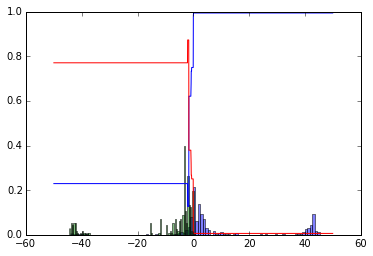

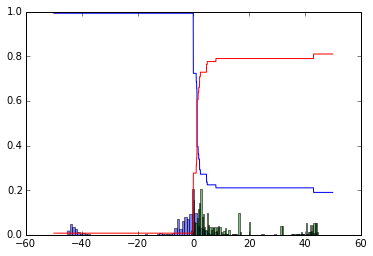

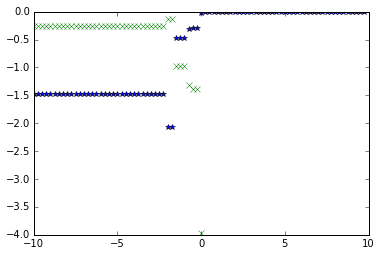

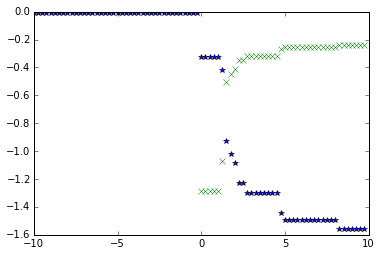

ID=SPY_208_2015.06.30_Put, number of spoofing trade = 9, total trades = 43
ID=SPY_207_2015.07.17_Put, number of spoofing trade = 4, total trades = 14
ID=SPY_205_2015.06.30_Put, number of spoofing trade = 2, total trades = 20
ID=HUM, number of spoofing trade = 0, total trades = 123
ID=HUM_200_2015.07.02_Call, number of spoofing trade = 0, total trades = 8
ID=HUM_177.5_2015.07.02_Put, number of spoofing trade = 1, total trades = 3
ID=HUM_207.5_2015.07.24_Call, number of spoofing trade = 0, total trades = 3
ID=HUM_205_2015.07.02_Call, number of spoofing trade = 0, total trades = 3
ID=HUM_210_2015.07.02_Call, number of spoofing trade = 0, total trades = 5
ID=HUM_205_2015.07.10_Call, number of spoofing trade = 2, total trades = 4
ID=HUM_207.5_2015.07.02_Call, number of spoofing trade = 0, total trades = 4
ID=HUM_220_2015.07.02_Call, number of spoofing trade = 2, total trades = 5
ID=HUM_165_2015.07.02_Put, number of spoofing trade = 1, total trades = 3
ID=PCLN, number of spoofing trade = 9, 

In [28]:
tmp = prepareTrainSet()
traindf = prepareTrainSetRec()   
mm = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True)
mm.train(traindf,show=True)


#df = pd.read_csv('./newdata/day1.csv')
dp = DataPrep(True)

res = pd.DataFrame()
#siri = df.loc[df['symbol']=='SIRI',:].copy()
total_spoof = 0
total_trades = 0
for ii in df['symbol'].unique():
    #if ii!='HUM_210_2015.07.02_Call':
    #    continue
    try:
    #    import pdb;pdb.set_trace()
        data = df.loc[df['symbol']==ii,:].copy()
        if len(data)<30:
            continue
        data = data.rename(columns={'exec_last_time':'execution_time','order_time':'order_entry_time','order_shares':'q_new','order_prc':'price','exec_shares':'q_exec','cxl_time':'cancel_entry_time'})
        data['prc_exec']= data['avg_prc']
        xx,hmmdata = dp.processData(data,verbose=0)
        total_trades += len(hmmdata)
        if len(hmmdata)>=3:
            res = mm.predict(hmmdata)
            total_spoof += len(res.loc[res['predSpoofing'],:])
            print 'ID={}, number of spoofing trade = {}, total trades = {}'.format(ii,len(res.loc[res['predSpoofing'],:]),len(hmmdata))
            tmp = xx.join(res[['pred','pred_prob','predSpoofing']])
            res = res.append(tmp)
    except ValueError:
        print 'error in--{}'.format(ii)
print 'total finding ={}'.format(total_spoof)
print 'total trades = {}'.format(total_trades)

/home/wangjia/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
-c:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---- Transition prob
state  next state
0      0             0.708082
       1             0.159228
       2             0.026538
       3             0.106152
1      0             0.211800
       1             0.659607
       2             0.075643
       3             0.052950
2      0             0.104000
       1             0.200000
       2             0.684000
       3             0.012000
3      0             0.185676
       1             0.111406
       2             0.015915
       3             0.687003
dtype: float64


-c:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


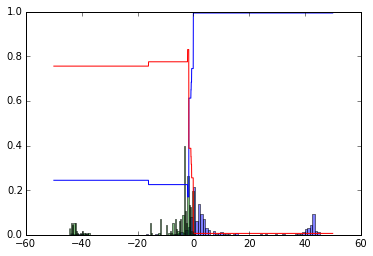

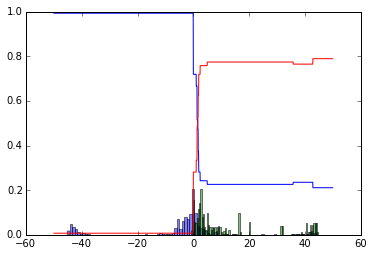

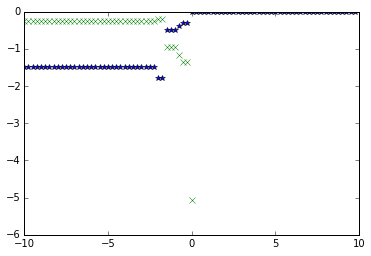

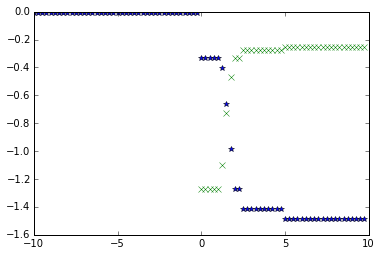

--Return--
> <ipython-input-15-93ab9466e816>(8)<module>()->None
-> import pdb;pdb.set_trace()
(Pdb) c
GPTJESTONS6
HPX128GYM
INT1369
JZ003WGS
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=JZ003WGS, number of spoofing trade = 1
LLLAAV
LLLBEIHE
LLLBEIXIA
LLLXINQI
PHX29GMJ
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=PHX29GMJ, number of spoofing trade = 17
PHX29GZ
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=PHX29GZ, number of spoofing trade = 5
PHX29LZ
PHX29LZL
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=PHX29LZL, number of spoofing trade = 14
PHX29MDX
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=PHX29MDX, number of spoofing trade = 14
PHX29NXD
----Data cleaning----
---- Feature calculation----
----- Prepare for HMM------
ID=PHX29NXD, number of spoofing trade = 1
PHX29SC
----Data cleaning----
---- Feature c

In [15]:
tmp = prepareTrainSet()
traindf = prepareTrainSetRec()   

            #mm = HMM(nState=4,TDFeaSet=['TimeDiff_min'],featureSet=['ewav_back buy/sell'],useAllFea=True,useDPGMM=True)
mm = HMM(nState=4,TDFeaSet=['TimeDiff_frwd','TimeDiff_back'],featureSet=['ewav_back buy/sell'],useAllFea=False,useDPGMM=True)
mm.train(traindf,show=True)

import pdb;pdb.set_trace()
df = pd.read_csv('./newdata/day1.csv')
dp = DataPrep(True)

res = pd.DataFrame()
siri = df.loc[df['symbol']=='SIRI',:].copy()
for ii in siri['id'].unique():
    #import pdb;pdb.set_trace()
    #data = siri.loc[siri['id']=='JZ003WGS',:].copy()
    #if not ii=='PHX29SC':
    #    continue
    #print ii
    data = siri.loc[siri['id']==ii,:].copy()
    if len(data)<30:
        continue
    data = data.rename(columns={'exec_last_time':'execution_time','order_time':'order_entry_time','order_shares':'q_new','order_prc':'price','exec_shares':'q_exec','cxl_time':'cancel_entry_time'})
    data['prc_exec']= data['avg_prc']
    xx,hmmdata = dp.processData(data)
    if len(hmmdata)>=3:
        res = mm.predict(hmmdata)
        print 'ID={}, number of spoofing trade = {}'.format(ii,len(res.loc[res['predSpoofing'],:]))        
        tmp = xx.join(res[['pred','pred_prob','predSpoofing']])
        res = res.append(tmp)
res.to_csv('res_siri.csv',index=False)

In [14]:
from sklearn.ensemble import RandomForestClassifier
xx = stats.gamma.rvs(a=2,size=1000)
yy = stats.norm.rvs(loc=-1,size=1000)
rf = RandomForestClassifier(n_estimators=10, max_depth=2)
label = np.array([1]*len(xx)+[0]*len(yy))
tmp = np.concatenate((xx,yy)).reshape((len(xx)+len(yy),1))
rf.fit(tmp,label)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [28]:
plt.hist(xx,bins=100,alpha=0.5)
plt.show()

In [45]:
tt = np.arange(-10,10,0.05)
tt = tt.reshape((len(tt),1))

In [49]:
pred = rf.predict_proba(tt)
plt.plot(tt,pred[:,1])
plt.show()

In [43]:
rf.fit(tmp,label)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [43]:
xx.ix[res.index]

,orderid,cancelled buy,cancelled sell,date,exec buy,exec sell,microsecond,price,side,time,...,ewav_back canc buy,ewav_back canc sell,ewav_back exec buy,ewav_back exec sell,ewav_back buy/sell,ewav_back sell/buy,ewav_back buy exec/total,ewav_back buy exec+canc,ewav_back sell exec/total,ewav_back sell exec+canc
6,JZ003WGS-13-37,0,0,01/13/15,100,0,37354000000,3.64,B,NaN,...,8.423464e-10,6.224145e-09,1.000000e+02,0.00000,1.353353e-01,7.389056e+00,1.000000,1.000000e+02,0,6.224145e-09
7,JZ003WGS-14-37,0,0,01/13/15,0,100,37450000000,3.61,S,NaN,...,3.179971e-20,2.349698e-19,3.775135e-09,100.00000,1.353353e-01,7.389056e+00,1.000000,3.775135e-09,1,1.000000e+02
1769,JZ003WGS-3553-37,0,0,01/13/15,0,100,50884000000,3.54,S,NaN,...,1.730590e+02,4.873203e-30,0.000000e+00,100.00000,3.551237e+31,2.815920e-32,0.000000,1.730590e+02,1,1.000000e+02
1770,JZ003WGS-3554-37,0,0,01/13/15,100,0,50928000000,3.55,B,NaN,...,2.890379e-03,8.139077e-35,1.000000e+02,0.00167,3.551237e+31,2.815920e-32,0.999971,1.000029e+02,1,1.670170e-03
